# IMAGING mode single scan under TMC control and monitoring
All tests under TMC control and monitoring are approached as black box tests, where no direct LOW CSP control is done.

This notebook performs a basic scan operated through TMC, performing correlation on simulated noise input and capturing the visibility output from CSP.   
**Note: the source delays in this notebook are supplied by TMC.**

## References
https://developer.skao.int/projects/ska-telmodel/en/latest/schemas/tmc/ska-tmc.html

Verification of observation sequence (ADR-8)

Equivalent to subarray state:
* Assign resources: EMPTY -> RESOURCING -> IDLE
* Configure: IDLE -> CONFIGURING -> READY
* Scan: READY -> SCANNING -> READY
* Configure: READY -> CONFIGURING -> READY
* Scan: READY -> SCANNING -> READY
* End: READY -> IDLE
* Release resources: IDLE -> RESOURCING -> EMPTY

## Notebook setup

### TANGO / Kubernetes settings

Change the settings below to point to the correct Kubernetes namespace and TANGO database.

In [60]:
TANGO_DB_PORT = 10000
TANGO_DB_SVC = "ska-low-csp-databaseds"
TANGO_DB_NAMESPACE = "ska-low-csp-dev"
TANGO_DB_HOST = f"tango://{TANGO_DB_SVC}.{TANGO_DB_NAMESPACE}.svc.cluster.local:{TANGO_DB_PORT}"

### Notebook settings

Change the settings below to change the notebook behaviour.

#### Settings that users may want to change for typical IMAGING mode

Notes:
- for multiple subarray, more options will open up for the SUBARRAY_ID tests
- with zoom modes more options will open up for assigned channel ranges in the CHANNEL_IDS

In [61]:
# allow any valid subarray id (at the moment fixed to 4 subarray): subarray_id = {1,2,3,4}
# - what happens if you say 5
SUBARRAY_ID = 1

# allow any combination of stations (seems to spec between 1 and 512 in TMC)
# even though only 18 stations for AA1 the telescope model already has the stations and their locations built in and therefor the simulated system will not react as on site (see low-layout.json in references)
# - what happens if you have 0 stations
# - what happens if you have a list of stations and one or two of the station IDs repeat
# - what happens if you have a list of stations and one or two of the station IDs repeat and the list of IDs are not in ascending (sorted) order
# - what happens if you have a list of all the stations (all 512) and one of the stations repeat so the list is 513
# - station IDs must be between 1 and 512, what happens if you assign 0 or 513
# - test with 1 station (ENGINEERING state, this may be a useful check if you want to test or bring back a station after technical work)
# - test with 2 stations (single baseline, both IMAGING and ENGINEERING state)
# - test with 4 stations (phase and amplitude closure, both IMAGING and ENGINEERING state)
# - test with 18 stations (IMAGING mode)
STATION_IDS = [425, 511]  # longest baseline
STATION_IDS = [345,350,352,431]  # AA0.5
STATION_IDS = [345,346,347,348,349,350,351,352,353,354,355,356,429,430,431,432,433,434]  # AA1

# stations in subarray, solely for the DSP input, not significant for LOW CSP just so you understand the information that appears later
STATION_LABLES = ['E16-3','N16-5']  # longest baseline
STATION_LABLES = ['S8-1','S8-6','S9-2','S10-3']  # AA0.5
STATION_LABLES = ['S8-1','S8-2','S8-3','S8-4','S8-5','S8-6','S9-1','S9-2','S9-3','S9-4','S9-5','S9-6','S10-1','S10-2','S10-3','S10-4','S10-5','S10-6']  # AA1

# allow any valid number of channels (currently we have 96 SPS channels over 75MHz)
# - what happens if you have an empty list (0 channels)
# - can you assign a value outside of the range (e.g. 100 channels)
# - can you assign a frequency range above or below the 300MHz bandwidth (<50MHz or >350MHz)
# - what happens if you have duplicate channel indices in the list?
CHANNEL_IDS = list(range(100, 108))


#### Settings to keep stable (or keep as pre-defined) for IMAGING mode

Notes:
- number of unique scan IDs must equal the number of scans in an execution block
- with PST mode multiple station beam test options will come up

In [62]:
# unique scan ID per scan (for the moment assume per source)
SCAN_ID = 1235

# not sure how multiple subarrays will work and PST will probably have multiple beams (for the moment stick to one beam, one subarray)
STATION_BEAM_ID = 1

#### System/setup settings

In [63]:
SUBSTATION_ID = 0  # because of bug in TMC (see SKB-328)

VIS_FW = "vis:0.0.8-main.82aa561a:gitlab"

CNIC_FW_VERSION = "0.1.13-main.dae9a5c8"
CNIC_FW_SOURCE = "gitlab"  #"nexus"

SPS_SPEAD_VERSION = 3
SCAN_DURATION_S = 58.0

SDP_IP = "192.168.1.1"
FSP_ID = 1

### Imports

In [64]:
%pip install --extra-index-url https://artefact.skao.int/repository/pypi-internal/simple git+https://gitlab.com/ska-telescope/ska-low-csp-test

Looking in indexes: https://pypi.org/simple, https://artefact.skao.int/repository/pypi-internal/simple
  Cloning https://gitlab.com/ska-telescope/ska-low-csp-test to /tmp/pip-req-build-lomdgxdg
  Running command git clone --filter=blob:none --quiet https://gitlab.com/ska-telescope/ska-low-csp-test /tmp/pip-req-build-lomdgxdg
  Resolved https://gitlab.com/ska-telescope/ska-low-csp-test to commit 53e92a7ece51ff6edaf02dd96edfa3d2e61acefc
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


In [65]:
import datetime
import itertools
import json
import logging
import os
import pprint
import sys
import time
from io import BytesIO

from PIL import Image
from matplotlib import pyplot as plt

import tango
from ska_control_model import AdminMode, ObsState
from ska_low_csp_test.cbf import visibilities
from ska_low_csp_test.domain import plotting
from ska_low_csp_test.domain.spead import LowCbfSdpSpeadStationBaselineMapping
from ska_low_csp_test.synchronisation import wait_for_condition

### Logging setup

This will ensure everything will log to cell outputs.
IPython defaults to logging to `stderr` but the cells need to `stdout`.

In [66]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s",
    level=logging.INFO,
    stream=sys.stdout,
)

logger = logging.getLogger()

Convenience logic common to all LOW CSP notebooks

In [67]:
import typing

def format_port_status(connector_: tango.DeviceProxy) -> str:
    """Pretty-print P4 Port information to string.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :returns: formatted string, listing for each port:
        the port identifier,
        the port enable status,
        the port status,
        the configured port speed,
        the ingress packet count of the switch port,
        the egress packet count of the switch port
    """
    ports_ = get_port_status(connector_)

    return "\n".join(
        [
            "  ".join(
                [
                    "Port: {port[port]:>4}",
                    "Enable: {port[enable]!s:<5}",
                    "Up: {port[up]!s:<5}",
                    "Speed: {port[speed]:<5}",
                    "Rx: {port[packets_received]:8}",
                    "Tx: {port[packets_sent]:8}",
                ]
            ).format(port=each)
            for each in ports_.values()
        ]
    )


def get_port_status(connector_: tango.DeviceProxy) -> dict[str, dict[str, str]]:
    """Retrieve P4 Packet Counters.

    :returns: dictionary of the configured attributes and packet counts of each P4 switch port
    """
    port_status_json = connector_.PortStatus
    port_status_obj = json.loads(port_status_json)
    return {
        each["$PORT_NAME"]: {
            "port": each["$PORT_NAME"],
            "enable": each["$PORT_ENABLE"],
            "up": each["$PORT_UP"],
            "speed": each["$SPEED"],
            "packets_received": each["packets_received"],
            "packets_sent": each["packets_sent"],
        }
        for each in port_status_obj["Ports_Status"]
    }


def get_ports_counts(
    connector_: tango.DeviceProxy,
    ports_: list[str],
) -> dict[str, tuple[int, int]]:
    """
    Return the number of packets received and send through each P4 switch ports connected.

    :param connector: CbfConnectorProxy Tango DeviceProxy wrapper
    :param ports: a list of port identifiers to query
    :returns: a list a received and sent packet count tuple for each port
    """
    port_counts, port_status = {}, get_port_status(connector_)
    for port_ in ports_:
        try:
            status = port_status[port_]
            port_count = status["packets_received"], status["packets_sent"]
        except KeyError:
            # Unknown port
            port_count = (0, 0)
        port_counts[port_] = port_count
    return port_counts


def parse_hardware_connections(
    allocator: tango.DeviceProxy,  # pylint: disable = redefined-outer-name
) -> dict[str, str]:
    """Convert `allocator.hardware_connections` prop to `{ "serial": "port" }`.

    :param allocator: Allocator Tango device
    :returns: dictionary with FPGA device serial numbers as the keys, and the
    network switch port numbers as values
    """
    name = "hardware_connections"  # pylint: disable = redefined-outer-name
    prop = allocator.get_property(name)

    alveo_props = [each.split() for each in filter(lambda x: "alveo" in x, prop[name])]
    alveo_ports = [list(filter(lambda x: "alveo" in x or "port" in x, each)) for each in alveo_props]

    ports_ = list(itertools.chain.from_iterable(filter(lambda x: "port" in x, each) for each in alveo_ports))
    port_it = [each.strip("port=") for each in ports_]

    alveos = list(itertools.chain.from_iterable(filter(lambda x: "alveo" in x, each) for each in alveo_ports))
    alveo_it = [each.strip("alveo=") for each in alveos]

    return dict(zip(alveo_it, port_it))


def wait_for_attribute_value(
    device_: tango.DeviceProxy,
    attribute: str,
    value: typing.Any = True,
    failure_message: str = "Timed out waiting for attribute value",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until an attribute has a certain value

    :param device: Tango device proxy with the attribute to check
    :param attribute: The name of the attribute
    :param value: Expected value (defaults to True)
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for attribute value".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period  in seconds (in reality
    it could be longer due to delays waiting for each attribute read)
    :raises RuntimeError: if expected value not seen before timing out
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            if device_.read_attribute(attribute).value == value:
                break
        except tango.DevFailed as err_:
            raise AttributeError from err_

        time.sleep(poll_interval_seconds)
    else:
        raise RuntimeError(f"{failure_message} after {timeout_sec} sec")


def wait_for_device_response(
    device_: tango.DeviceProxy,
    failure_message: str = "Timed out waiting for device to respond",
    timeout_sec: int = 120,
) -> None:
    """
    Wait until a device responds.

    :param device: Tango device proxy to wait for
    :param failure_message: Message for the exception on failure.
    Defaults to "Timed out waiting for device to respond".
    A note about duration is appended.
    :param timeout_sec: Approximate time-out period in seconds
    :raises RuntimeError: if the device does not respond in time
    """
    deadline = time.time() + timeout_sec
    poll_interval_seconds = 2
    while time.time() < deadline:
        try:
            device_.ping()
            return
        except tango.ConnectionFailed:
            time.sleep(poll_interval_seconds)
    raise RuntimeError(f"{failure_message} after {timeout_sec} sec")

## Set up CNIC

Always use noise input for operational level tests via TMC in IMAGING mode

Notes:
- CW and noise for zoom modes (mimic spectral lines and testing rechannelisation)
- Pulsed input for PST and PSS modes

In [68]:
cnic_vd_config = {
    "sps_packet_version": SPS_SPEAD_VERSION,
    "stream_configs": [
        {
            "scan": SCAN_ID,
            "subarray": SUBARRAY_ID,
            "station": station,
            "substation": SUBSTATION_ID,
            "frequency": channel,
            "beam": STATION_BEAM_ID,
            "sources": {
                "x": [
                    {"tone": False, "seed": 1000, "scale": 4000},
                ],
                "y": [
                    {"tone": False, "seed": 1000, "scale": 4000},
                ],
            },
        }
        for station in STATION_IDS
        for channel in CHANNEL_IDS
    ],
}

In [69]:
cnic_vd = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/1")
# cnic_rx = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/cnic/2")
cnic_rx = cnic_vd  # duplex mode

for cnic in [cnic_rx, cnic_vd]:
    if not cnic.activePersonality == "cnic":
        logger.info("Programming CNIC %s", cnic.name())
        cnic.set_timeout_millis(300_000)
        cnic.SelectPersonality(json.dumps({
            "version": CNIC_FW_VERSION,
            "source": CNIC_FW_SOURCE,
            "memory": "4095Ms:4095Ms:4095Mi:4095Mi",
        }))

    logger.info("Resetting CNIC %s", cnic.name())
    try:
        cnic.StopSourceDelays()
    except:
        pass
    cnic.CallMethod(json.dumps({"method": "stop_receive"}))
    cnic.CallMethod(json.dumps({"method": "reset"}))
    wait_for_attribute_value(cnic, "hbm_pktcontroller__duplex", False)
    cnic.hbm_pktcontroller__duplex = cnic_rx == cnic_vd
print("Done.")

2024-11-08 08:52:26,248 | INFO : Resetting CNIC low-cbf/cnic/1
2024-11-08 08:52:27,284 | INFO : Resetting CNIC low-cbf/cnic/1
Done.


### Fix configuration in TMC mocks

The SDP mocks created by TMC have hard-coded receive addresses, which incorrectly contain host names instead of IP addresses.
This causes an issue in LOW-CBF, so we manually overwrite them in the mock.

Related: [SKB-463](https://jira.skatelescope.org/browse/SKB-463)

In [70]:
pp = pprint.PrettyPrinter(indent=2)

sdp_subarray_mock = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-sdp/subarray/{SUBARRAY_ID:02}")

print("SDP receive addresses before fix")
pp.pprint(json.loads(sdp_subarray_mock.receiveAddresses))

sdp_subarray_mock.SetDirectreceiveAddresses(
    json.dumps(
        {
            "science_A": {
                "host": [[0, SDP_IP], [2000, SDP_IP]],
                "port": [[0, 9000, 1], [2000, 9000, 1]],
            },
            "target:a": {
                "vis0": {
                    "function": "visibilities",
                    "host": [[0, SDP_IP]],
                    "port": [[0, 9000, 1]],
                }
            },
            "calibration:b": {
                "vis0": {
                    "function": "visibilities",
                    "host": [[0, SDP_IP]],
                    "port": [[0, 9000, 1]],
                }
            },
        }
    )
)

print("SDP receive addresses after fix")
pp.pprint(json.loads(sdp_subarray_mock.receiveAddresses))

SDP receive addresses before fix
{ 'calibration:b': { 'vis0': { 'function': 'visibilities',
                               'host': [[0, '192.168.1.1']],
                               'port': [[0, 9000, 1]]}},
  'science_A': { 'host': [[0, '192.168.1.1'], [2000, '192.168.1.1']],
                 'port': [[0, 9000, 1], [2000, 9000, 1]]},
  'target:a': { 'vis0': { 'function': 'visibilities',
                          'host': [[0, '192.168.1.1']],
                          'port': [[0, 9000, 1]]}}}
SDP receive addresses after fix
{ 'calibration:b': { 'vis0': { 'function': 'visibilities',
                               'host': [[0, '192.168.1.1']],
                               'port': [[0, 9000, 1]]}},
  'science_A': { 'host': [[0, '192.168.1.1'], [2000, '192.168.1.1']],
                 'port': [[0, 9000, 1], [2000, 9000, 1]]},
  'target:a': { 'vis0': { 'function': 'visibilities',
                          'host': [[0, '192.168.1.1']],
                          'port': [[0, 9000, 1]]}}}

## Turn on telescope

First, turn on the CSP sub-system by toggling the `AdminMode` and waiting for everything to come online.

Then, turn on the telescope through TMC by issuing the `TelescopeOn()` command.

The reason for the on command is that TMC is offline when started, this needs to be moved to online in order to communicate to the subsystems.

In [71]:
csp_controller = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/control/0")
csp_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-csp/subarray/{SUBARRAY_ID:02}")

tmc_central_node = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_central/central_node")
tmc_subarray = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_subarray_node/{SUBARRAY_ID}")
tmc_csp_subarray_leaf_node = tango.DeviceProxy(f"{TANGO_DB_HOST}/ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}")

Ensure LOW CSP in known state for test run

**Some low level control is necessary when turning the telescope ON**    
The TelescopeOn() does not propagate down to lower level successfull. It is necessary to first turn on LOW CSP and then run the TelescopeON() command to establish connections with the subsystems once available.

In [72]:
csp_controller.adminMode = AdminMode.OFFLINE
wait_for_condition(lambda: not csp_controller.isCommunicating, timeout_s=10.0)

In [73]:
csp_controller.adminMode = AdminMode.ONLINE
wait_for_condition(lambda: csp_controller.isCommunicating, timeout_s=10.0)
wait_for_condition(lambda: csp_subarray.state() == tango.DevState.ON, timeout_s=10.0)

In [74]:
tmc_central_node.TelescopeOn()
wait_for_condition(lambda: tmc_central_node.state() == tango.DevState.ON, timeout_s=10.0)
wait_for_condition(lambda: tmc_subarray.state() == tango.DevState.ON, timeout_s=10.0)

## Abort + Restart

Perform an `Abort` followed by `Restart` if the TMC subarray is not in an `EMPTY` state.

In [75]:
if tmc_subarray.obsState != ObsState.EMPTY:
    if tmc_subarray.obsState != ObsState.ABORTED:
        logger.info("Invoking Abort command on subarray")
        tmc_subarray.Abort()
        wait_for_condition(lambda: tmc_subarray.obsState == ObsState.ABORTED, timeout_s=60.0)

    logger.info("Invoking Restart command on subarray")
    tmc_subarray.Restart()
    wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=60.0)

## Assign Resources + Configure

The difference between assignResources and Configure from the TMC point of view is how information is communicated between the surrounding subsystems. Mainly the difference is that DSP has to be set up with the whole execution block beforehand, while MCCS and CSP is controlled on a scan by scan basis.

What this means:
An "execution block" in the scope of LOW CSP is the sequence of steps: assignResources->Configure->scan->Configure->scan->...->configure->scan->End->releaseResources

TMC communicates all the scans (and associated targets) to SDP upfront. SDP then associates the setup and scan information to this execution block to a unique "eb_id" (execution block id). This all happens above LOW CSP and needs to be understood conceptually, but from our point of view happens silently at the upper level.
Once set up, SDP will use the "scan_id" to perform the data analysis and delay correction calculations. Thus, for LOW CSP it is important to ensure that we ensure independent scan id's per scan in the configuration schema. It will have no viable impact on the simulated enviroment, but is operationally correct.

The TMC delay corrections, via the TMC delay model, provides only geometric delays for the stations. It has not additional manipulation functionality. If such functionality is still required, a lower level implementation from LMC using the CBF delay polynomial simulator is required.    
Using the TMC delay corrections, means the baseline delay corrections between the phase center and the stations. We would expect these to be updated as the source is "tracked" during a scan, as well as when repointing to difference sources between scans. To communicate the change of target, the MCCS block in configuration schema is used.

In short, the MCCS and CSP blocks in the assignResouces and Configuration JSONs have important parameters to set by LOW CSP during TMC command and control. The SDP block associated with the mode (IMAGING/PST) is a dummy required for the simulator and mainly cosmetic for us to keep aligned with the test case to make the implementation easier to ready.

In [76]:
# TMC config constants
EB_ID = "eb-test-20220916-00000"

The `sdp` block in the assign resources schema is a dummy from the LOW CSP point of view. The functionality related to this block lives outside the low csp leave node    
It is added as a dummy schema for the TMC SDP simulator and only needs to conform to schema validation needs, the data in the block is not used at LOW CSP level.

In [77]:
DUMMY_SDP = {
    "interface": "https://schema.skao.int/ska-sdp-assignres/0.4",
    "resources": {"receptors": STATION_LABLES, "receive_nodes": 1},

    "execution_block": {
        "eb_id": EB_ID,
        "context": {},
        "max_length": 3600.0,
        "beams": [{"beam_id": "vis0", "function": "visibilities"}],
        "scan_types": [
            {"scan_type_id": ".default", "beams": {"vis0": {"channels_id": "vis_channels", "polarisations_id": "all"}}},
            {"scan_type_id": "target:a", "derive_from": ".default", "beams": {"vis0": {"field_id": "field_a"}}},
            {"scan_type_id": "calibration:b", "derive_from": ".default", "beams": {"vis0": {"field_id": "field_b"}}},
        ],
        "channels": [
            {
                "channels_id": "vis_channels",
                "spectral_windows": [
                    {
                        "spectral_window_id": "fsp_1_channels",
                        "count": 4,
                        "start": 0,
                        "stride": 2,
                        "freq_min": 350000000.0,
                        "freq_max": 368000000.0,
                        "link_map": [[0, 0], [200, 1], [744, 2], [944, 3]],
                    }
                ],
            }
        ],
        "polarisations": [{"polarisations_id": "all", "corr_type": ["XX", "XY", "YX", "YY"]}],
        "fields": [
            {
                "field_id": "field_a",
                "phase_dir": {"ra": [123.0], "dec": [-60.0], "reference_time": "...", "reference_frame": "ICRF3"},
                "pointing_fqdn": "...",
            },
            {
                "field_id": "field_b",
                "phase_dir": {"ra": [123.0], "dec": [-60.0], "reference_time": "...", "reference_frame": "ICRF3"},
                "pointing_fqdn": "...",
            },
        ],
    },
    "processing_blocks": [
        {
            "pb_id": "pb-test-20220916-00000",
            "script": {"kind": "realtime", "name": "test-receive-addresses", "version": "0.7.1"},
            "sbi_ids": ["sbi-mvp01-20210623-00000"],
            "parameters": {},
        }
    ],
}

In [78]:
print(DUMMY_SDP)

{'interface': 'https://schema.skao.int/ska-sdp-assignres/0.4', 'resources': {'receptors': ['S8-1', 'S8-2', 'S8-3', 'S8-4', 'S8-5', 'S8-6', 'S9-1', 'S9-2', 'S9-3', 'S9-4', 'S9-5', 'S9-6', 'S10-1', 'S10-2', 'S10-3', 'S10-4', 'S10-5', 'S10-6'], 'receive_nodes': 1}, 'execution_block': {'eb_id': 'eb-test-20220916-00000', 'context': {}, 'max_length': 3600.0, 'beams': [{'beam_id': 'vis0', 'function': 'visibilities'}], 'scan_types': [{'scan_type_id': '.default', 'beams': {'vis0': {'channels_id': 'vis_channels', 'polarisations_id': 'all'}}}, {'scan_type_id': 'target:a', 'derive_from': '.default', 'beams': {'vis0': {'field_id': 'field_a'}}}, {'scan_type_id': 'calibration:b', 'derive_from': '.default', 'beams': {'vis0': {'field_id': 'field_b'}}}], 'channels': [{'channels_id': 'vis_channels', 'spectral_windows': [{'spectral_window_id': 'fsp_1_channels', 'count': 4, 'start': 0, 'stride': 2, 'freq_min': 350000000.0, 'freq_max': 368000000.0, 'link_map': [[0, 0], [200, 1], [744, 2], [944, 3]]}]}], 'po

In [79]:
tmc_assign_resources = {
    "interface": "https://schema.skao.int/ska-low-tmc-assignresources/4.0",
    "subarray_id": SUBARRAY_ID,
    "mccs": {
        "interface": "https://schema.skao.int/ska-low-mccs-controller-allocate/3.0",
        "subarray_beams": [
            {
                "subarray_beam_id": STATION_BEAM_ID,
                "apertures": [{"station_id": station, "aperture_id": f"AP{station:03}.01"} for station in STATION_IDS],
                "number_of_channels": len(CHANNEL_IDS),
            }
        ],
    },
    "csp": { # SKB-463
        "pss": {
            "pss_beam_ids": [],
        },
        "pst": {
            "pst_beam_ids": [],
        },
    },
    "sdp": DUMMY_SDP,
}

In [80]:
print(tmc_assign_resources)

{'interface': 'https://schema.skao.int/ska-low-tmc-assignresources/4.0', 'subarray_id': 1, 'mccs': {'interface': 'https://schema.skao.int/ska-low-mccs-controller-allocate/3.0', 'subarray_beams': [{'subarray_beam_id': 1, 'apertures': [{'station_id': 345, 'aperture_id': 'AP345.01'}, {'station_id': 346, 'aperture_id': 'AP346.01'}, {'station_id': 347, 'aperture_id': 'AP347.01'}, {'station_id': 348, 'aperture_id': 'AP348.01'}, {'station_id': 349, 'aperture_id': 'AP349.01'}, {'station_id': 350, 'aperture_id': 'AP350.01'}, {'station_id': 351, 'aperture_id': 'AP351.01'}, {'station_id': 352, 'aperture_id': 'AP352.01'}, {'station_id': 353, 'aperture_id': 'AP353.01'}, {'station_id': 354, 'aperture_id': 'AP354.01'}, {'station_id': 355, 'aperture_id': 'AP355.01'}, {'station_id': 356, 'aperture_id': 'AP356.01'}, {'station_id': 429, 'aperture_id': 'AP429.01'}, {'station_id': 430, 'aperture_id': 'AP430.01'}, {'station_id': 431, 'aperture_id': 'AP431.01'}, {'station_id': 432, 'aperture_id': 'AP432.01'}

In [81]:
tmc_cfg = {
    "interface": "https://schema.skao.int/ska-low-tmc-configure/4.0",
    "mccs": {
        "subarray_beams": [
            {
                "subarray_beam_id": STATION_BEAM_ID,
                "update_rate": 0.0,
                "logical_bands": [
                    {"start_channel": 80, "number_of_channels": 16},
                    {"start_channel": 384, "number_of_channels": 16},
                ],
                "apertures": [
                    {"aperture_id": f"AP{station:03}.01", "weighting_key_ref": "aperture1"} for station in STATION_IDS
                ],
                "sky_coordinates": {
                    "reference_frame": "ICRS",
                    "c1": 180.0,
                    "c2": 45.0,
                },
            }
        ],
    },
    "sdp": {
        "interface": "https://schema.skao.int/ska-sdp-configure/0.4",
        "scan_type": "target:a",
    },
    "csp": {
        "interface": "https://schema.skao.int/ska-low-csp-configure/3.2",
        "common": {
            "config_id": "sbi-mvp01-20200325-00001-science_A",
            "eb_id": EB_ID,
        },
        "lowcbf": {
            "stations": {
                "stns": [[station, SUBSTATION_ID] for station in STATION_IDS],
                "stn_beams": [
                    {
                        "beam_id": STATION_BEAM_ID,
                        "freq_ids": CHANNEL_IDS,
                    }
                ],
            },
            "vis": {
                "fsp": {"firmware": VIS_FW, "fsp_ids": [FSP_ID]},
                "stn_beams": [
                    {
                        "stn_beam_id": STATION_BEAM_ID,
                        "integration_ms": 849,
                    }
                ],
            },
        },
    },
    "tmc": {"scan_duration": SCAN_DURATION_S},
}

In [82]:
tmc_central_node.AssignResources(json.dumps(tmc_assign_resources))

[array([2], dtype=int32),
 ['1731055986.3841355_10071466039459_AssignResources']]

In [83]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [84]:
tmc_subarray.Configure(json.dumps(tmc_cfg))

[array([2], dtype=int32), ['1731055990.4874842_121336417746807_Configure']]

In [85]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=60.0)

## Set up P4 routing

In [86]:
cbf_allocator = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/allocator/0")
cbf_connector = tango.DeviceProxy(f"{TANGO_DB_HOST}/low-cbf/connector/0")

In [87]:
def parse_hardware_connections(
    allocator: tango.DeviceProxy,  # pylint: disable = redefined-outer-name
) -> dict[str, str]:
    """Convert `allocator.hardware_connections` prop to `{ "serial": "port" }`.

    :param allocator: Allocator Tango device
    :returns: dictionary with FPGA device serial numbers as the keys, and the
    network switch port numbers as values
    """
    name = "hardware_connections"  # pylint: disable = redefined-outer-name
    prop = allocator.get_property(name)

    alveo_props = [each.split() for each in filter(lambda x: "alveo" in x, prop[name])]
    alveo_ports = [list(filter(lambda x: "alveo" in x or "port" in x, each)) for each in alveo_props]

    ports_ = list(itertools.chain.from_iterable(filter(lambda x: "port" in x, each) for each in alveo_ports))
    port_it = [each.strip("port=") for each in ports_]

    alveos = list(itertools.chain.from_iterable(filter(lambda x: "alveo" in x, each) for each in alveo_ports))
    alveo_it = [each.strip("alveo=") for each in alveos]

    return dict(zip(alveo_it, port_it))


fpga_ports = parse_hardware_connections(cbf_allocator)
logger.info("FPGA port mapping: %s", fpga_ports)

2024-11-08 08:53:27,136 | INFO : FPGA port mapping: {'XFL1SZ2IUU2I': '9/0', 'XFL1BB1SEWXK': '10/0', 'XFL1XXQM0FKW': '11/0', 'XFL1EG4H5YXY': '12/0'}


In [88]:
cbf_connector.UpdateSdpIpEntry(
    json.dumps({"sdp_ip": [{"src": {"ip": SDP_IP}, "dst": {"port": fpga_ports[cnic_rx.serialnumber]}}]})
)

[array([0], dtype=int32), ['SDP_IP_Routes_Updated']]

In [89]:
logger.info("P4 basic routing table: %s", cbf_connector.BasicRoutingTable)
logger.info("P4 PSR routing table: %s", cbf_connector.PsrRoutingTable)
logger.info("P4 SDP IP routing table: %s", cbf_connector.SdpIpRoutingTable)
logger.info("P4 SDP MAC routing table: %s", cbf_connector.SdpMacRoutingTable)
logger.info("P4 SPEAD Multiplier routing table: %s", cbf_connector.SpeadMultiplierRoutingTable)
logger.info("P4 SPEAD Unicast routing table: %s", cbf_connector.SpeadUnicastRoutingTable)

2024-11-08 08:53:30,560 | INFO : P4 basic routing table: {"Basic": [{"ingress port": "0/0", "port": "0/0"}]}
2024-11-08 08:53:30,563 | INFO : P4 PSR routing table: {"PSR": [{"Beam": "1", "port": "1/0"}]}
2024-11-08 08:53:30,567 | INFO : P4 SDP IP routing table: {"SDP_IP": [{"IP_Address": "192.168.1.1", "port": "9/0"}]}
2024-11-08 08:53:30,571 | INFO : P4 SDP MAC routing table: {"SDP_MAC": [{"IP_Address": "0.0.0.0", "MAC": "00:00:00:00:00:00"}]}
2024-11-08 08:53:30,577 | INFO : P4 SPEAD Multiplier routing table: {"Spead": [{"Frequency": 0, "Beam": 0, "Sub_array": 0, "session": 0}]}
2024-11-08 08:53:30,585 | INFO : P4 SPEAD Unicast routing table: {"Spead": [{"Frequency": "100", "Beam": "1", "Sub_array": "1", "port": "12/0"}, {"Frequency": "101", "Beam": "1", "Sub_array": "1", "port": "12/0"}, {"Frequency": "102", "Beam": "1", "Sub_array": "1", "port": "12/0"}, {"Frequency": "103", "Beam": "1", "Sub_array": "1", "port": "12/0"}, {"Frequency": "104", "Beam": "1", "Sub_array": "1", "port": 

In [90]:
correlator_serial = json.loads(cbf_allocator.fsps)[f"fsp_{FSP_ID:02}"][0]
print("Correlator FPGA has serial number", correlator_serial)

correlator_fqdn = json.loads(cbf_allocator.procDevFqdn)[correlator_serial]
print("Correlator FPGA TANGO device:", correlator_fqdn)

correlator = tango.DeviceProxy(f"{TANGO_DB_HOST}/{correlator_fqdn}")

Correlator FPGA has serial number XFL1EG4H5YXY
Correlator FPGA TANGO device: low-cbf/processor/0.0.2


In [91]:
cbf_connector.ResetPortStatistics()

[array([0], dtype=int32), ['Ports Statistics Reset']]

In [92]:
# TODO - remove Clear when issues with UpdateBasicEntry are resolved
cbf_connector.ClearBasicTable("")

[array([0], dtype=int32), ['Routes_Deleted']]

In [93]:
serialno_port = parse_hardware_connections(cbf_allocator)
print(serialno_port)

cnic_vd_port = serialno_port[cnic_vd.serialnumber]
print("CNIC VD is connected to P4 port", cnic_vd_port)

correlator_port = serialno_port[correlator_serial]
print("Correlator FPGA is connected to P4 port", correlator_port)

cnic_rx_port = serialno_port[cnic_rx.serialnumber]
print("CNIC RX is connected to P4 port", cnic_rx_port)

ports = [cnic_vd_port, correlator_port, cnic_rx_port]

for name, cnic, port in ("Tx", cnic_vd, cnic_vd_port), ("XF", correlator, correlator_port), ("Rx", cnic_rx, cnic_rx_port):
    print(f"{name}: port: {port:>4}, S/N: {cnic.serialnumber}, {cnic.name()}")

print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()
print("Routing tables:")
print(f"  Arp:               {cbf_connector.ArpRoutingTable}")
print(f"  Basic:             {cbf_connector.BasicRoutingTable}")
print(f"  PSR:               {cbf_connector.PsrRoutingTable}")
print(f"  SDP IP:            {cbf_connector.SdpIpRoutingTable}")
print(f"  SDP MAC:           {cbf_connector.SdpMacRoutingTable}")
print(f"  SPEAD Mulftiplier: {cbf_connector.SpeadMultiplierRoutingTable}")
print(f"  SPEAD Unicast:     {cbf_connector.SpeadUnicastRoutingTable}")

{'XFL1SZ2IUU2I': '9/0', 'XFL1BB1SEWXK': '10/0', 'XFL1XXQM0FKW': '11/0', 'XFL1EG4H5YXY': '12/0'}
CNIC VD is connected to P4 port 9/0
Correlator FPGA is connected to P4 port 12/0
CNIC RX is connected to P4 port 9/0
Tx: port:  9/0, S/N: XFL1SZ2IUU2I, low-cbf/cnic/1
XF: port: 12/0, S/N: XFL1EG4H5YXY, low-cbf/processor/0.0.2
Rx: port:  9/0, S/N: XFL1SZ2IUU2I, low-cbf/cnic/1

P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:      237  Tx:        0
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 11/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 12/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 32/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0

Routing tables:
  Arp:               {"ARP": [{"IP": "0.0.0.0", "MAC": "00:00:00:00:00:00"}]}
  Basic:             {"Basic": [{"ingress 

## Configure CNIC Rx

Configure the CNIC Rx to capture visibility data.

In [94]:
N_VISIBILITIES = 15
OUTPUT_PACKET_COUNT = 144 * len(CHANNEL_IDS) * (N_VISIBILITIES + 1)
OUTPUT_PACKET_SIZE = 60 # 80  # to avoids PTP packets

In [95]:
pcap_file_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S_") + "vis-via-tmc.pcap"
pcap_file_path = os.path.join("/test-data", pcap_file_name)

cnic_rx.CallMethod(
    json.dumps(
        {
            "method": "receive_pcap",
            "arguments": {
                "out_filename": pcap_file_path,
                "packet_size": OUTPUT_PACKET_SIZE,
                "n_packets": OUTPUT_PACKET_COUNT,
            },
        }
    )
)

'None'

## Configure CNIC-VD

Configure the CNIC-VD and point it to the source delays from TMC.
The CNIC-VD will automatically start transmitting once it receives delays.

In [96]:
cnic_vd.ConfigureVirtualDigitiser(json.dumps(cnic_vd_config))

In [97]:
tm_source_delays = {}
tm_source_delays[SUBARRAY_ID] = {}
tm_source_delays[SUBARRAY_ID][STATION_BEAM_ID] = [f"ska_low/tm_leaf_node/csp_subarray{SUBARRAY_ID:02}", "DelayModel"]

cnic_vd.StartTmSourceDelays(json.dumps(tm_source_delays))

## Scan

### Start scan on TMC

In [98]:
tmc_subarray.Scan(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-scan/4.0",
            "scan_id": SCAN_ID,
        }
    )
)

[array([2], dtype=int32), ['1731056035.4971893_264054767140529_Scan']]

In [99]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.SCANNING, timeout_s=10.0)

## Print delay coefficients provided by TMC

In [100]:
while tmc_subarray.obsState == ObsState.SCANNING:
    pp.pprint(json.loads(tmc_csp_subarray_leaf_node.DelayModel))
    time.sleep(10)

print("Done.")

{ 'cadence_sec': 300.0,
  'config_id': 'sbi-mvp01-20200325-00001-science_A',
  'interface': 'https://schema.skao.int/ska-low-csp-delaymodel/1.0',
  'start_validity_sec': 784371828.024257,
  'station_beam': 1,
  'station_beam_delays': [ { 'station_id': 345,
                             'substation_id': 0,
                             'xypol_coeffs_ns': [ -1653.4314700096832,
                                                  0.06500749101901412,
                                                  2.3802279329956413e-05,
                                                  -5.761347229167248e-11,
                                                  -1.0549570100794083e-14,
                                                  1.9012542253297548e-20],
                             'ypol_offset_ns': 0.0},
                           { 'station_id': 346,
                             'substation_id': 0,
                             'xypol_coeffs_ns': [ -1570.6009256616787,
                                 

## Wait for capture to finish

In [101]:
logger.info("Target Number of packets to capture: %d", OUTPUT_PACKET_COUNT)

count = 0
while not cnic_rx.finished_receive:
    packets_received = cnic_rx.hbm_pktcontroller__rx_packet_count
    logger.info("Packets received: %d", cnic_rx.hbm_pktcontroller__rx_packet_count)
    time.sleep(5)
    count += 1
    if count > 20:
        logger.warning("Still not finished receiving, something is wrong")
        break

logger.info("Finished writing PCAP file: %s", pcap_file_path)

2024-11-08 08:55:06,904 | INFO : Target Number of packets to capture: 18432
2024-11-08 08:55:06,907 | INFO : Finished writing PCAP file: /test-data/20241108_085347_vis-via-tmc.pcap


In [102]:
print()
print(f"P4 port status:\n{format_port_status(cbf_connector)}")
print()


P4 port status:
Port:  1/0  Enable: True   Up: True   Speed: 100G   Rx:     2441  Tx:        0
Port:  9/0  Enable: True   Up: True   Speed: 100G   Rx:  4948992  Tx:    79419
Port: 10/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 11/0  Enable: True   Up: True   Speed: 100G   Rx:        0  Tx:        0
Port: 12/0  Enable: True   Up: True   Speed: 100G   Rx:    79488  Tx:  4948992
Port: 32/0  Enable: True   Up: False  Speed: 100G   Rx:        0  Tx:        0



## Wait for scan to finish and tear down subarray

The scan should finish automatically, after which the subarray becomes `READY` again.
After that, deconfigure and release resources.

In [103]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.READY, timeout_s=SCAN_DURATION_S)

In [104]:
tmc_subarray.End()

[array([2], dtype=int32), ['1731056113.1457875_60371057892018_End']]

In [105]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.IDLE, timeout_s=10.0)

In [106]:
tmc_central_node.ReleaseResources(
    json.dumps(
        {
            "interface": "https://schema.skao.int/ska-tmc-releaseresources/3.0",
            "subarray_id": SUBARRAY_ID,
            "release_all": True,
        }
    )
)

[array([2], dtype=int32),
 ['1731056116.159363_71521608208130_ReleaseResources']]

In [107]:
tmc_subarray.obsState

<obsState.EMPTY: 0>

In [108]:
wait_for_condition(lambda: tmc_subarray.obsState == ObsState.EMPTY, timeout_s=10.0)

### Reset CNIC-VD

In [109]:
cnic_vd.enable_vd = False

In [110]:
# known issue with unsubscribing from TM delays
for _ in range(4):
    try:
        cnic_vd.StopSourceDelays()
        time.sleep(0.1)
    except:
        pass

In [111]:
cnic_vd.CallMethod(json.dumps({"method": "stop_receive"}))
cnic_vd.CallMethod(json.dumps({"method": "reset"}))

'None'

## Check output

Note: to be able to display the output, make sure the kernel is able to read the contents of the SSD disk where PCAP files are stored.

This should be supported automatically when running this notebook on the DS-PSI BinderHub.

Alternatively, you can mount the corresponding disk on your local system using `sshfs` (installable via apt).
I use the following command to create the mount:

```sh
sudo sshfs -o allow_other,default_permissions,IdentityFile=/home/sander/.ssh/id_rsa ubuntu@172.16.1.5:/mnt/ssd /mnt/clp-k8s-fpga-worker-1
```

After making sure the disk is accessible through the local file system, update the cell below to point to the mount point.

In [112]:
PATH_TO_PCAP_DISK = "/mnt/cnic-data"

In [113]:
pcap_output = visibilities.unpack_pcap_file(pcap_file_path.replace("/test-data", PATH_TO_PCAP_DISK))

2024-11-08 08:55:28,283 | INFO : Start reading SPEAD data from file: /mnt/cnic-data/20241108_085347_vis-via-tmc.pcap
2024-11-08 08:55:29,916 | INFO : Finished reading SPEAD data from file: /mnt/cnic-data/20241108_085347_vis-via-tmc.pcap


In [114]:
pcap_output.metadata

ScaID  Chann  Epoch  ZoomI  VisFl  Resol SrcID  BeaID  Subar     FreHz  \
0      1235      0      0      0      0     32  b'L'      1      1  77736975   
1      1235      1      0      0      0     32  b'L'      1      1  77742400   
2      1235      2      0      0      0     32  b'L'      1      1  77747825   
3      1235      3      0      0      0     32  b'L'      1      1  77753251   
4      1235      4      0      0      0     32  b'L'      1      1  77758676   
...     ...    ...    ...    ...    ...    ...   ...    ...    ...       ...   
1146   1235   1147      0      0      0     32  b'L'      1      1  83959848   
1147   1235   1148      0      0      0     32  b'L'      1      1  83965273   
1148   1235   1149      0      0      0     32  b'L'      1      1  83970699   
1149   1235   1150      0      0      0     32  b'L'      1      1  83976124   
1150   1235   1151      0      0      0     32  b'L'      1      1  83981549   

      Firmw  Basel      Hardw     Integ        Frequ  
0      2157    171  890204344  0.849347  5425.347168  
1      2157    171  890204344  0.849347  5425.347168  
2      2157    171  890204344  0.849347  5425.347168  
3      2157    171  890204344  0.849347  5425.347168  
4      2157    171  890204344  0.849347  5425.347168  
...     ...    ...        ...       ...          ...  
1146   2157    171  890204344  0.849347  5425.347168  
1147   2157    171  890204344  0.849347  5425.347168  
1148   2157    171  890204344  0.849347  5425.347168  
1149   2157    171  890204344  0.849347  5425.347168  
1150   2157    171  890204344  0.849347  5425.347168  

[1151 rows x 15 columns]

In [115]:
pcap_output.data

<xarray.Dataset> Size: 101MB
Dimensions:             (channel_id: 1151, baseline: 171, polarization: 4,
                         epoch_offset: 16)
Coordinates:
  * channel_id          (channel_id) int64 9kB 0 1 2 3 4 ... 1148 1149 1150 1151
  * baseline            (baseline) <U8 5kB '(0, 0)' '(1, 0)' ... '(17, 17)'
  * polarization        (polarization) <U2 32B 'XX' 'XY' 'YX' 'YY'
  * epoch_offset        (epoch_offset) uint64 128B 784371833538231240 ... 784...
    scan_id             (epoch_offset) uint64 128B 1235 1235 1235 ... 1235 1235
Data variables: (12/16)
    784371833538231240  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371834387577800  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371835236924360  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371836086270920  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371836935617480  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371837784964040  (channel_id, baseline, polarization) complex64 6MB 0j...
    ...                  ...
    784371842031696840  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371842881043400  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371843730389960  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371844579736520  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371845429083080  (channel_id, baseline, polarization) complex64 6MB 0j...
    784371846278429640  (channel_id, baseline, polarization) complex64 6MB 0j...
Attributes:
    baselines_auto_idx:   [0, 2, 5, 9, 14, 20, 27, 35, 44, 54, 65, 77, 90, 10...
    baselines_cross_idx:  [1, 3, 4, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, ...

### Plot output

In [116]:
baseline_idx = 1  # cross-correlation baseline
station_baseline_mapping = LowCbfSdpSpeadStationBaselineMapping([[station, SUBSTATION_ID] for station in STATION_IDS])

### XY channel averaged phase vs time

In [117]:
plot = plotting.plot_channel_averaged_phase_vs_time(
    pcap_output,
    baseline_idx,
    visibilities.Polarization.XY,
)
img = Image.open(BytesIO(plot))
plt.imshow(img, aspect="auto")
plt.axis("off")
plt.show()

### XY time averaged phase vs channel

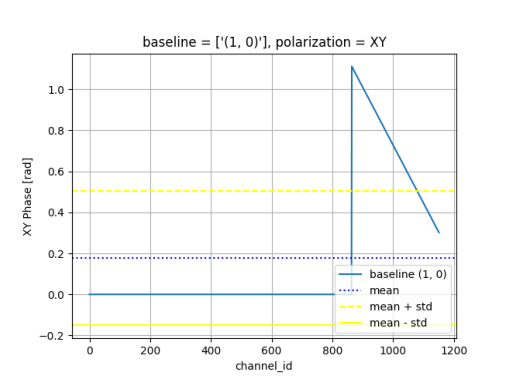

In [118]:
plot = plotting.plot_time_averaged_phase_vs_channel(
    pcap_output,
    [baseline_idx],
    visibilities.Polarization.XY,
    SCAN_ID,
    trim_first_s=5,
)
img = Image.open(BytesIO(plot))
plt.imshow(img, aspect="auto")
plt.axis("off")
plt.show()